# On Benford's Law and NYC Taxi Trip Durations

In this notebook, we will demonstrate how [Benford's Law](https://en.wikipedia.org/wiki/Benford%27s_law) is reflected in the first digit of time durations of [NYC taxi trips](https://www.kaggle.com/c/nyc-taxi-trip-duration/data).

Last night, I woke up at 2AM and could not get back to sleep and started TV surfing and stublled upon Netflix [Connected, the Digits eposide](https://www.netflix.com/title/81031737). The reporter was talking about the usage of Benford's law. As I was watching it, I was constantly saying "No Way!".  At the end of the episode, I looked up the [law](https://en.wikipedia.org/wiki/Benford%27s_lawhttps://en.wikipedia.org/wiki/Benford%27s_law) (oh...and never went back to sleep that night due to the excitement :-) and went about replicating the curve with some data to "see" the curve.

Though the law can be applied to a "small" set, the more data you have, the better. That is why I used my fav dataset (NYC Taxi Data) for BigData analysis. And, a 1 through 9, as a first digit in the data, has to have a very good likelihood of occurance.  For example, latitude and longitude values in a restricted area like NYC are NOT good candicate, as 7 and 4 are the only values (see below the extent values).  However, a trip duration value is a GREAT candidate.

So...this notebook uses [Apache Spark](https://spark.apache.org/) to prep the data, in such that we can "see" a Benford curve in the processed output.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sms
import matplotlib.pyplot as plt

In [2]:
plt.style.use('dark_background')

Download the [data](https://www.kaggle.com/c/nyc-taxi-trip-duration/datahttps://www.kaggle.com/c/nyc-taxi-trip-duration/data) into a folder named `kaggle` in your home directory.

In [3]:
load_path = os.path.expanduser(os.path.join("~","kaggle","nyc-taxi-trip-duration","train.csv"))

Load the data into a Spark dataframe and map it to a SQL view named `v0`.

In [4]:
schema = ",".join([
    "id string",
    "vendor_id string",
    "pickup_datetime timestamp",
    "dropoff_datetime timestamp",
    "passenger_count integer",
    "pickup_longitude double",
    "pickup_latitude double",
    "dropoff_longitude double",
    "dropoff_latitude double",
    "store_and_fwd_flag string",
    "trip_duration integer"
])

df = spark\
    .read\
    .format("csv")\
    .option("header",True)\
    .option("parserLib", "univocity")\
    .option("mode", "permissive")\
    .schema(schema)\
    .load(load_path)\
    .drop("id","vendor_id","passenger_count","store_and_fwd_flag")\
    .selectExpr("*","hour(pickup_datetime) pickup_hour")\
    .cache()

df.createOrReplaceTempView("v0")

Restrict the pickups and dropoffs to an area around Manhattan.

![](media/NYC.png)

In [5]:
lon_min,lat_min,lon_max,lat_max = (-75.08761590197491, 40.122033125848525, -72.33354542760787, 41.68167992377412)

Accumulate the first digit of the trip duration field statistics and collect the result as a Pandas dataframe.

Note here we are convering the `trip_duration` numerical value to a string value, in such that we can pick up the first digit as a character using `substr` function.

In [6]:
pdf = spark.sql(f"""
select b,count(1) pop
from(
select substr(cast(trip_duration as string),0,1) b
from v0
where pickup_longitude between {lon_min} and {lon_max}
and pickup_latitude between {lat_min} and {lat_max}
and dropoff_longitude between {lon_min} and {lon_max}
and dropoff_latitude between {lat_min} and {lat_max}
and trip_duration > 0
)
group by b
order by b
""")\
    .toPandas()

Add a percent pandas series.

In [7]:
pdf['pct'] = 100.0 * pdf['pop'] / pdf['pop'].sum()

Compute the Benford values.

In [8]:
bf = 100.0 * np.log10(1.0+1.0/np.arange(1,10,1))

Plot the occurence and the Benford curve.

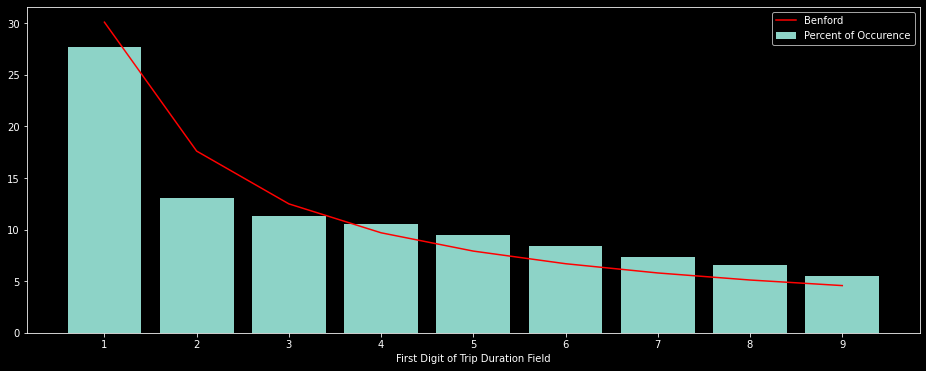

In [11]:
plt.figure(figsize=(16,6))
bar = plt.bar(pdf['b'],pdf['pct'], label='Percent of Occurence')
plt.plot(pdf['b'], bf, 'r', label='Benford')
plt.xlabel('First Digit of Trip Duration Field')
# plt.xticks(rotation=90)
plt.legend()
plt.show()

# MIND BLOWN !!!